In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns

df_vehicle_crashes = pd.read_parquet("../optimized_datasets/vehicle_crashes_cleaned.parquet")

In [11]:
df_vehicle_crashes.head(10)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,...,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3
0,2021-09-11,2:39,NaN,<NA>,NaN,NaN,WHITESTONE EXPRESSWAY,2.0,0.0,0,...,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,4455765,Sedan,Sedan,NaN
1,2022-03-26,11:45,NaN,<NA>,NaN,NaN,QUEENSBORO BRIDGE UPPER,1.0,0.0,0,...,0,1,0,Pavement Slippery,NaN,NaN,4513547,Sedan,NaN,NaN
2,2023-11-01,1:29,BROOKLYN,11230,40.621790,-73.970024,OCEAN PARKWAY,1.0,0.0,0,...,0,1,0,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan
3,2022-06-29,6:55,NaN,<NA>,NaN,NaN,THROGS NECK BRIDGE,0.0,0.0,0,...,0,0,0,Following Too Closely,Unspecified,NaN,4541903,Sedan,Pick-up Truck,NaN
4,2022-09-21,13:21,NaN,<NA>,NaN,NaN,BROOKLYN BRIDGE,0.0,0.0,0,...,0,0,0,Passing Too Closely,Unspecified,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN
5,2023-04-26,13:30,NaN,<NA>,NaN,NaN,WEST 54 STREET,0.0,0.0,0,...,0,0,0,Unspecified,Unspecified,NaN,4623759,Sedan,Box Truck,NaN
6,2023-11-01,7:12,NaN,<NA>,NaN,NaN,HUTCHINSON RIVER PARKWAY,0.0,0.0,0,...,0,0,0,Following Too Closely,Driver Inattention/Distraction,NaN,4675709,Sedan,Station Wagon/Sport Utility Vehicle,NaN
7,2023-11-01,8:01,NaN,<NA>,NaN,NaN,WEST 35 STREET,0.0,0.0,0,...,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,4675769,Sedan,NaN,NaN
8,2023-04-26,22:20,NaN,<NA>,NaN,NaN,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4623865,Sedan,Pick-up Truck,NaN
9,2021-09-11,9:35,BROOKLYN,11208,40.667202,-73.866500,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4456314,Sedan,NaN,NaN


In [12]:
print(df_vehicle_crashes["CRASH DATE"].min(), df_vehicle_crashes["CRASH DATE"].max())

2012-07-01 00:00:00 2025-04-08 00:00:00


# Simple map with points

In [13]:
# Center on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=13)

# Sample 1000 collisions to avoid browser lag
sample = df_vehicle_crashes.dropna(subset=["LATITUDE", "LONGITUDE"]).sample(1000)

for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.75
    ).add_to(m)

m

C:\Users\gisle\AppData\Local\Temp\ipykernel_183584\3643990322.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour


<Axes: title={'center': 'Collisions by Hour'}, xlabel='CRASH_HOUR'>

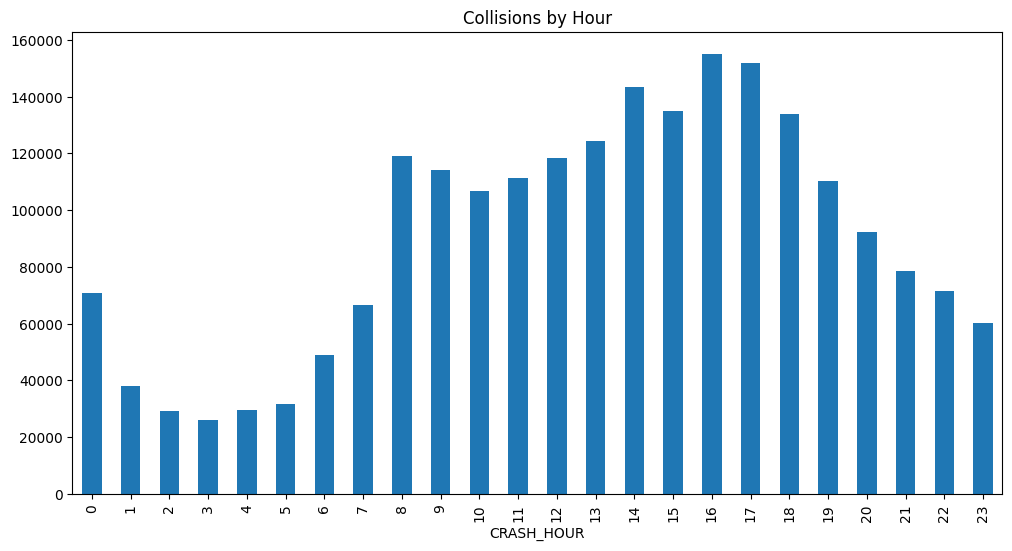

In [14]:
plt.figure(figsize=(12, 6))

df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour
df_vehicle_crashes["CRASH_HOUR"].value_counts().sort_index().plot(kind="bar", title="Collisions by Hour")

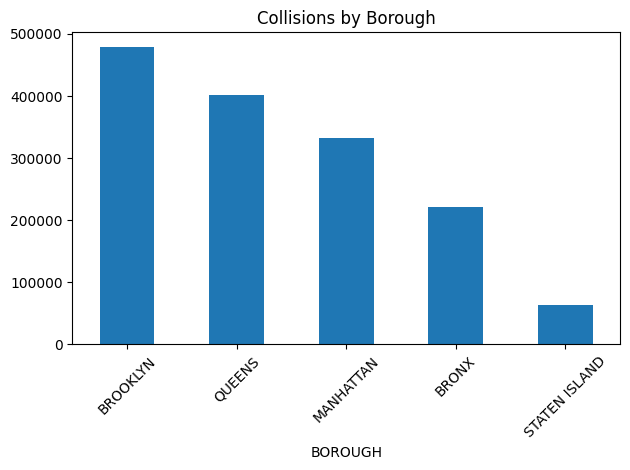

In [15]:
df_vehicle_crashes["BOROUGH"].value_counts().plot(kind="bar", title="Collisions by Borough")
plt.xticks(rotation=45)
plt.tight_layout()  # Optional: prevents label cutoff
plt.show()


In [16]:
df_vehicle_crashes["VEHICLE TYPE CODE 1"] = (
    df_vehicle_crashes["VEHICLE TYPE CODE 1"]
    .str.lower()
    .str.strip()
)

vehicle_type_mapping = {
    # Common car types
    "sedan": "Sedan",
    "4 dr sedan": "Sedan",
    "2 dr sedan": "Sedan",
    
    "station wagon/sport utility vehicle": "SUV",
    "sport utility / station wagon": "SUV",
    "passenger vehicle": "Passenger Vehicle",
    "pick-up truck": "Pickup Truck",
    "pick-up": "Pickup Truck",
    "p/u": "Pickup Truck",
    "van": "Van",
    "box truck": "Box Truck",
    
    # Variations
    "taxi": "Taxi",
    "taxicab": "Taxi",
    "t.a.x.i": "Taxi",
    "taxy": "Taxi",
    
    "bus": "Bus",
    "bus ": "Bus",   # with trailing space
    "b u s": "Bus",
    
    "motorcycle": "Motorcycle",
    "motorbike": "Motorcycle",
    "moped": "Moped",
    "motorscooter": "Motorcycle",
    
    "ambulance": "Ambulance",
    "ambul": "Ambulance",
    "amb": "Ambulance",
    
    "e-bike": "E-Bike",
    "e-scooter": "E-Scooter",
    
    # Catch-alls
    "unknown": "Unknown",
    "other": "Other"
}

df_vehicle_crashes["VEHICLE TYPE CLEANED"] = df_vehicle_crashes["VEHICLE TYPE CODE 1"].replace(vehicle_type_mapping)

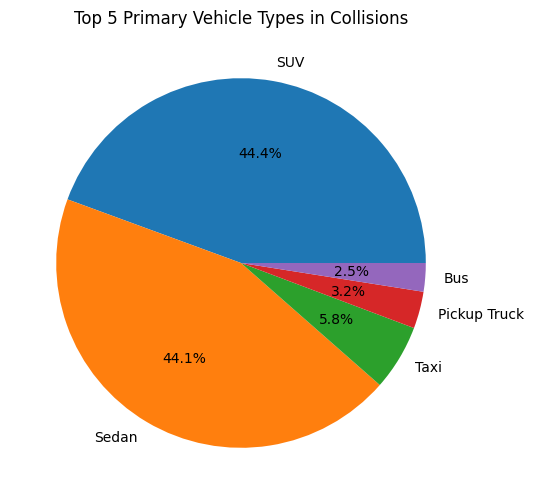

In [19]:
plt.figure(figsize=(20, 6))

# Get top 5 after dropping 'Passenger Vehicle'
top_vehicles = (
    df_vehicle_crashes["VEHICLE TYPE CLEANED"]
    .value_counts()
    .drop("Passenger Vehicle", errors="ignore")
    .head(5)
)

ax = top_vehicles.plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Top 5 Primary Vehicle Types in Collisions",
    ylabel=""
)

plt.show()

In [18]:
# List df_vehicle_crashes["VEHICLE TYPE CODE 1"] top 50
top_50_vehicle_types = df_vehicle_crashes["VEHICLE TYPE CLEANED"].value_counts().head(50)

print(top_50_vehicle_types)

VEHICLE TYPE CLEANED
SUV                               665523
Sedan                             661243
Passenger Vehicle                 416206
Taxi                               86186
Pickup Truck                       48446
Bus                                37343
Van                                35240
Box Truck                          25801
Other                              22973
Unknown                            19954
bike                               16753
Motorcycle                         14687
large com veh(6 or more tires)     14397
small com veh(4 tires)             13216
tractor truck diesel               10967
livery vehicle                     10481
Ambulance                           8331
dump                                4234
convertible                         4024
E-Bike                              3783
Moped                               2780
pk                                  2748
E-Scooter                           2666
flat bed                            

In [20]:
df_vehicle = pd.read_parquet("../optimized_datasets/vehicle_crashes_vehicle_cleaned.parquet")